In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run init.py

Setting up variables & DB connection for experiment:

*******************
_exp3
*******************

Snorkel session connected to:  postgres:///snorkel_exp3


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Rebuild text
from sklearn_bridge import recreate_text_representation, candidate_dict_to_df
import sklearn, pickle, time, seaborn
import pandas as pd
import numpy as np
from itertools import product

In [3]:
from MLutils import report_to_df, train_evaluate, diversity_heatmap

In [4]:
import pickle
with open(path_candidate_dict_pkl, 'rb') as f:
    candidate_dict = pickle.load(f)

ids = dict()
for splt in candidate_dict.keys():
    print "Split = %i : imported %i candidates" %(splt, len(candidate_dict[splt].keys()))
    ids[splt] = set(candidate_dict[splt].keys()) # import candidate ids too

Split = 0 : imported 3840 candidates
Split = 1 : imported 3242 candidates
Split = 2 : imported 8221 candidates
Split = 3 : imported 14727 candidates


** Load cands (as cand objects for LSTM) ** 

In [5]:
from snorkel.annotations import load_marginals

In [6]:
train_cands = session.query(REGULATOR).filter(REGULATOR.split == 0).order_by(REGULATOR.id).all()
val_cands = session.query(REGULATOR).filter(REGULATOR.split == 1).order_by(REGULATOR.id).all()
test_cands = session.query(REGULATOR).filter(REGULATOR.split == 2).order_by(REGULATOR.id).all()
unlab_cands = session.query(REGULATOR).filter(REGULATOR.split == 3).order_by(REGULATOR.id).all()

print('Training set:\t{0} candidates'.format(len(train_cands)))
print('Val set:\t{0} candidates'.format(len(val_cands)))
print('Test set:\t{0} candidates'.format(len(test_cands)))
print('Unlab set:\t{0} candidates'.format(len(unlab_cands)))

Training set:	3840 candidates
Val set:	3242 candidates
Test set:	8221 candidates
Unlab set:	14727 candidates


** Load cands (as ML feature matrix) ** 

In [7]:
from utils import keep_cands

In [8]:
# Decide on text representation
trim_text = True
trim_window = 5
use_lemmas = True

df_train = candidate_dict_to_df(candidate_dict[0],trim_text=trim_text, window=trim_window, lemmas = use_lemmas ).sort_index()
df_val = candidate_dict_to_df(candidate_dict[1],trim_text=trim_text, window=trim_window, lemmas = use_lemmas ).sort_index()
df_test = candidate_dict_to_df(candidate_dict[2],trim_text=trim_text, window=trim_window, lemmas = use_lemmas ).sort_index()
df_unlab = candidate_dict_to_df(candidate_dict[3],trim_text=trim_text, window=trim_window, lemmas = use_lemmas ).sort_index()

# Drop cands not in database already
df_train = keep_cands(df_train,ids[0])
df_val = keep_cands(df_val,ids[1])
df_test = keep_cands(df_test,ids[2])
df_unlab = keep_cands(df_unlab,ids[3])

print('Training set:\t{0} candidates'.format(len(df_train)))
print('Val set:\t{0} candidates'.format(len(df_val)))
print('Test set:\t{0} candidates'.format(len(df_test)))
print('Unlab set:\t{0} candidates'.format(len(df_unlab)))

Training set:	3840 candidates
Val set:	3242 candidates
Test set:	8221 candidates
Unlab set:	14727 candidates


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [10]:
text_vectorizer = TfidfVectorizer(ngram_range=[0,3])

In [11]:
X_train = text_vectorizer.fit_transform(df_train.text)
X_val = text_vectorizer.transform(df_val.text)
X_test = text_vectorizer.transform(df_test.text)

X_unlab = text_vectorizer.transform(df_unlab.text)

** Load labels **

In [12]:
y_train = np.array(df_train.label)
y_val = np.array(df_val.label)
y_test = np.array(df_test.label)

y_unlab = np.array(df_unlab.label) # WARNING: contains nan (or is nan fully)
unlab_marginals = load_marginals(session, split=3) # safe - loads them after ordering by candidate id

# Learning curves

In [13]:
# from sklearn.model_selection import validation_curve
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.utils import shuffle

## Write learning_curve function

In [14]:
from MLutils import *

In [15]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from snorkel.learning import reRNN

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [16]:
# TODO: undersample consistently train candidates

In [17]:
train_cands[0]

REGULATOR(Span("juglone", sentence=11193, chars=[45,51], words=[7,7]), Span("AR", sentence=11193, chars=[117,118], words=[20,20]))

In [18]:
from sklearn.utils import shuffle

In [19]:
# Balance & shuffle indices
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42,return_indices=True)
X_train,y_train, ind = rus.fit_sample(X_train,y_train)
train_cands = [train_cands[i] for i in ind] 

# X_train,y_train, ind = shuffle(X_train,y_train, ind )

ind = range(len(y_train))
X_train,y_train, train_cands = shuffle(X_train,y_train, train_cands )


In [20]:
# label integrity check
for i in range(len(train_cands)):
    if not train_cands[i].gold_labels[0].value == y_train[i]:
        print 'Label missmatch',i
        raise ValueError('Label missmatch (index %i)'%i)

In [21]:
from scipy.sparse import csr_matrix,vstack
import numpy as np
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.utils import shuffle
from copy import deepcopy

** Given X_train, y_train (full training set to perform incremental splits)
and optionally X_init, y_init (to start the initial validation curve from that point onwards) **

In [22]:
### define function inputs  ###

clf = LogisticRegression()
cv_splits = 3 # for cross-validating and finding variance in VALIDATION set
# X_init: the training dataset on beginning of the learning curve (spot 0)
# X_increm: the additional examples for plotting incremental learning curves

## construct dummy dataset
splt_sizes = np.array([ 0.1, 0.33, 0.55, 0.78, 1.])

X_init, y_init = X_train, y_train
X_increm, y_increm = X_test, y_test

print 'X_init', X_init.shape, len(y_init)
print 'X_increm', X_increm.shape, len(y_increm)


X_init (2060, 29546) 2060
X_increm (8221, 29546) 8221


In [23]:
X_unlab

<14727x29546 sparse matrix of type '<type 'numpy.float64'>'
	with 455730 stored elements in Compressed Sparse Row format>

[0.00000000e+00 2.99626534e-04 8.08581025e-04 9.34727710e-04
 2.51976470e-03 2.06688936e-02 3.23881431e-02 4.79251720e-02
 5.39117891e-02 6.18100766e-02 8.28845022e-02 9.46029700e-02
 1.19649926e-01 1.35796738e-01 1.51018803e-01 2.20040329e-01
 2.97883789e-01 7.02116211e-01 7.79959671e-01 8.48981197e-01
 8.64203262e-01 8.80350074e-01 9.05397030e-01 9.17115498e-01
 9.38189923e-01 9.46088211e-01 9.52074828e-01 9.67611857e-01
 9.79331106e-01 9.97480235e-01 9.99065272e-01 9.99191419e-01
 9.99700373e-01 1.00000000e+00]
<type 'numpy.ndarray'> <class 'scipy.sparse.csr.csr_matrix'>
[0 0 1 ... 1 0 1]
pred values [0 1]
y merged eval [0 1]
<type 'numpy.ndarray'> <class 'scipy.sparse.csr.csr_matrix'>
[0 0 0 ... 0 1 0]
pred values [0 1]
y merged eval [0 1]
<type 'numpy.ndarray'> <class 'scipy.sparse.csr.csr_matrix'>
[0 0 0 ... 0 1 0]
pred values [0 1]
y merged eval [0 1]


<module 'matplotlib.pyplot' from '/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

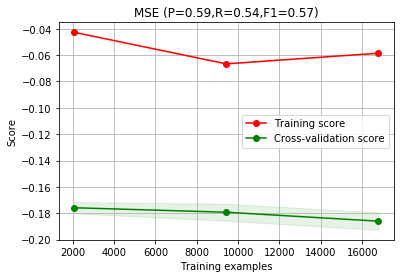

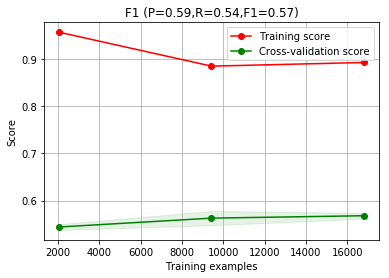

In [28]:
# with ML model
clf = LogisticRegression()
from MLutils import custom_learning_curve


train_sizes, train_mse, train_f1, valid_mse , valid_f1 , test_prf1 = custom_learning_curve(
    clf, X_unlab, unlab_marginals, X_val, y_val, X_init= X_train, y_init=y_train,
                      X_test = X_test, y_test = y_test, 
                      splt_sizes=np.array([0.1, 0.5, 1.  ])
                     )

plot_learning_curve(train_mse,valid_mse,train_sizes, 'MSE (P=%.2f,R=%.2f,F1=%.2f)'%(test_prf1))

plot_learning_curve(train_f1,valid_f1,train_sizes, title='F1 (P=%.2f,R=%.2f,F1=%.2f)'%(test_prf1))


In [154]:
unlab_marginals

array([2.99626534e-04, 2.99626534e-04, 2.99626534e-04, ...,
       9.99191419e-01, 9.99191419e-01, 2.99626534e-04])

In [29]:
test_prf1

(0.6450304259634888, 0.4808467741935484, 0.5509673693329483)

** Learning curves with snorkel RNN **

In [30]:
from sklearn.model_selection import learning_curve

In [62]:
clf = reRNN(seed=1701, deterministic=True)

In [32]:
# get train, val, test, ids
# query db for candidates (ordered by etc....)
# feed also labels.


In [ ]:
unlab_cands

In [132]:
a = np.array([1,2.,3,])

In [133]:
a.astype(int)

array([1, 2, 3])

[0.00000000e+00 2.99626534e-04 8.08581025e-04 9.34727710e-04
 2.51976470e-03 2.06688936e-02 3.23881431e-02 4.79251720e-02
 5.39117891e-02 6.18100766e-02 8.28845022e-02 9.46029700e-02
 1.19649926e-01 1.35796738e-01 1.51018803e-01 2.20040329e-01
 2.97883789e-01 7.02116211e-01 7.79959671e-01 8.48981197e-01
 8.64203262e-01 8.80350074e-01 9.05397030e-01 9.17115498e-01
 9.38189923e-01 9.46088211e-01 9.52074828e-01 9.67611857e-01
 9.79331106e-01 9.97480235e-01 9.99065272e-01 9.99191419e-01
 9.99700373e-01 1.00000000e+00]
<type 'numpy.ndarray'> <type 'list'>


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=2060  #epochs=5  batch size=64
[reRNN] Epoch 0 (5.63s)	Average loss=0.695932	Dev F1=20.38
[reRNN] Epoch 1 (13.85s)	Average loss=0.668709	Dev F1=30.00
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (22.11s)	Average loss=0.596815	Dev F1=29.22
[reRNN] Epoch 3 (30.35s)	Average loss=0.553697	Dev F1=29.29
[reRNN] Epoch 4 (38.56s)	Average loss=0.498617	Dev F1=29.42
[reRNN] Training done (41.31s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-1
[reRNN] Loaded model <reRNN>
[0. 1.]
[0. 1.]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 632 has argument past max length for model:	[arg ends at index 148; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 635 has argument past max length for model:	[arg ends at index 120; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 643 has argument past max length for model:	[arg ends at index 133; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 646 has argument past max length for model:	[arg ends at index 125; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2825 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2830 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2834 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 5256 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNot

<type 'numpy.ndarray'> <type 'list'>


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=6008  #epochs=5  batch size=64
[reRNN] Epoch 0 (22.60s)	Average loss=0.623157	Dev F1=43.59
[reRNN] Epoch 1 (48.80s)	Average loss=0.429453	Dev F1=42.84
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (76.53s)	Average loss=0.342279	Dev F1=42.63
[reRNN] Epoch 3 (102.57s)	Average loss=0.292739	Dev F1=46.51
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 4 (128.40s)	Average loss=0.260915	Dev F1=43.85
[reRNN] Training done (132.19s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-3
[reRNN] Loaded model <reRNN>
[0. 1.]
[0. 1.]
<type 'numpy.ndarray'> <type 'list'>


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=9818  #epochs=5  batch size=64
[reRNN] Epoch 0 (35.97s)	Average loss=0.572950	Dev F1=50.69
[reRNN] Epoch 1 (76.01s)	Average loss=0.405342	Dev F1=43.88
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (116.93s)	Average loss=0.333071	Dev F1=52.12
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 3 (157.54s)	Average loss=0.285178	Dev F1=45.69
[reRNN] Epoch 4 (197.73s)	Average loss=0.256897	Dev F1=50.08
[reRNN] Training done (201.57s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-2
[reRNN] Loaded model <reRNN>
[0. 1.]
[0. 1.]


<module 'matplotlib.pyplot' from '/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

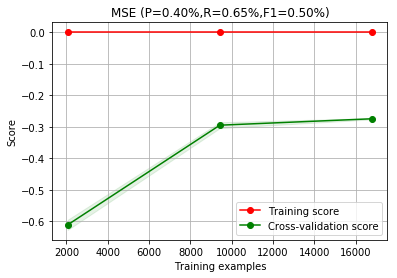

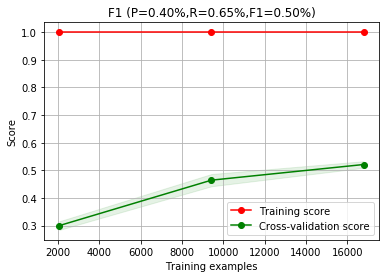

In [148]:
## with LSTM (Gold ---> unlab )

from MLutils import custom_learning_curve

train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   5,
    'dropout':    0.25,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 64,
    'dev_ckpt_delay': 0,
    'X_dev': val_cands, 
    'Y_dev': y_val,
    'verbose': False,
}

train_sizes, train_mse, train_f1, valid_mse , valid_f1 , test_prf1 = custom_learning_curve(
    clf, unlab_cands, unlab_marginals, val_cands, y_val, X_init= train_cands, y_init=y_train,
                      X_test = test_cands, y_test = y_test, fit_params = train_kwargs,
                      splt_sizes=np.array([0.1, 0.5, 1.  ])
                     )


plot_learning_curve(train_mse,valid_mse,train_sizes, 'MSE (P=%.2f%%,R=%.2f%%,F1=%.2f%%)'%(test_prf1))

plot_learning_curve(train_f1,valid_f1,train_sizes, title='F1 (P=%.2f%%,R=%.2f%%,F1=%.2f%%)'%(test_prf1))


In [145]:
y_train

array([ 1, -1, -1, ...,  1, -1, -1])

In [146]:
np.round(y_train)

array([ 1, -1, -1, ...,  1, -1, -1])

### KKKK

In [65]:
from sklearn.model_selection import ShuffleSplit

In [97]:
splitter = ShuffleSplit(n_splits=1, test_size=None, train_size=X_train.shape[0]-1, random_state=0)

In [117]:
splitter = ShuffleSplit(n_splits=1, test_size=None, train_size=len(y_train)-2, random_state=42)

In [118]:
ind = list(splitter.split(X_train))[0][0]

In [119]:
ind

array([1319, 1067,   29, ..., 1130, 1294,  860])

In [108]:
X_train[ind]

<2x29546 sparse matrix of type '<type 'numpy.float64'>'
	with 76 stored elements in Compressed Sparse Row format>

In [103]:
y_train[ind]

array([-1, -1, -1, ...,  1, -1, -1])

In [104]:
len(y_train)

2060

[0 1]
<type 'numpy.ndarray'> <type 'list'>


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=486  #epochs=5  batch size=64
[reRNN] Epoch 0 (1.60s)	Average loss=0.700717	Dev F1=16.92
[reRNN] Epoch 1 (5.65s)	Average loss=0.658249	Dev F1=11.91
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (9.82s)	Average loss=0.551306	Dev F1=28.97
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 3 (14.04s)	Average loss=0.408895	Dev F1=27.91
[reRNN] Epoch 4 (17.98s)	Average loss=0.379240	Dev F1=23.67
[reRNN] Training done (20.69s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-2
[reRNN] Loaded model <reRNN>


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 632 has argument past max length for model:	[arg ends at index 148; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 635 has argument past max length for model:	[arg ends at index 120; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 643 has argument past max length for model:	[arg ends at index 133; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 646 has argument past max length for model:	[arg ends at index 125; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2825 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2830 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2834 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 5256 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNot

<type 'numpy.ndarray'> <type 'list'>


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=990  #epochs=5  batch size=64
[reRNN] Epoch 0 (2.83s)	Average loss=0.697337	Dev F1=35.85
[reRNN] Epoch 1 (8.21s)	Average loss=0.710252	Dev F1=11.31
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (13.68s)	Average loss=0.565544	Dev F1=30.39
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 3 (19.10s)	Average loss=0.485584	Dev F1=29.11
[reRNN] Epoch 4 (24.39s)	Average loss=0.420718	Dev F1=30.50
[reRNN] Model saved as <reRNN>
[reRNN] Training done (27.26s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-4
[reRNN] Loaded model <reRNN>


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 632 has argument past max length for model:	[arg ends at index 148; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 635 has argument past max length for model:	[arg ends at index 120; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 643 has argument past max length for model:	[arg ends at index 133; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 646 has argument past max length for model:	[arg ends at index 125; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2825 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2830 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2834 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 5256 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNot

<type 'numpy.ndarray'> <type 'list'>


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=1344  #epochs=5  batch size=64
[reRNN] Epoch 0 (3.85s)	Average loss=0.699327	Dev F1=17.40
[reRNN] Epoch 1 (10.11s)	Average loss=0.678355	Dev F1=33.66
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (16.36s)	Average loss=0.593992	Dev F1=31.28
[reRNN] Epoch 3 (22.38s)	Average loss=0.526297	Dev F1=30.34
[reRNN] Epoch 4 (28.62s)	Average loss=0.473128	Dev F1=29.83
[reRNN] Training done (31.43s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-1
[reRNN] Loaded model <reRNN>


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 632 has argument past max length for model:	[arg ends at index 148; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 635 has argument past max length for model:	[arg ends at index 120; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 643 has argument past max length for model:	[arg ends at index 133; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 646 has argument past max length for model:	[arg ends at index 125; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2825 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2830 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2834 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 5256 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNot

<type 'numpy.ndarray'> <type 'list'>


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=1708  #epochs=5  batch size=64
[reRNN] Epoch 0 (4.59s)	Average loss=0.702398	Dev F1=25.77
[reRNN] Epoch 1 (11.94s)	Average loss=0.674935	Dev F1=30.95
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (19.13s)	Average loss=0.599928	Dev F1=29.95
[reRNN] Epoch 3 (26.16s)	Average loss=0.521863	Dev F1=34.00
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 4 (33.34s)	Average loss=0.465254	Dev F1=33.47
[reRNN] Training done (36.05s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-3
[reRNN] Loaded model <reRNN>


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 632 has argument past max length for model:	[arg ends at index 148; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 635 has argument past max length for model:	[arg ends at index 120; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 643 has argument past max length for model:	[arg ends at index 133; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 646 has argument past max length for model:	[arg ends at index 125; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2825 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2830 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2834 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 5256 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNot

<type 'numpy.ndarray'> <type 'list'>


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=2058  #epochs=5  batch size=64
[reRNN] Epoch 0 (5.66s)	Average loss=0.702834	Dev F1=4.78
[reRNN] Epoch 1 (13.89s)	Average loss=0.665730	Dev F1=32.01
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (22.31s)	Average loss=0.619388	Dev F1=31.17
[reRNN] Epoch 3 (30.79s)	Average loss=0.577623	Dev F1=22.65
[reRNN] Epoch 4 (38.91s)	Average loss=0.527851	Dev F1=30.97
[reRNN] Training done (41.76s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-1
[reRNN] Loaded model <reRNN>


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 632 has argument past max length for model:	[arg ends at index 148; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 635 has argument past max length for model:	[arg ends at index 120; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 643 has argument past max length for model:	[arg ends at index 133; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 646 has argument past max length for model:	[arg ends at index 125; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2825 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2830 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2834 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 5256 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNot

<module 'matplotlib.pyplot' from '/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

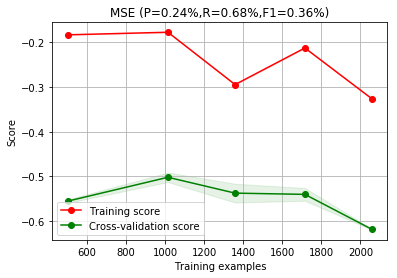

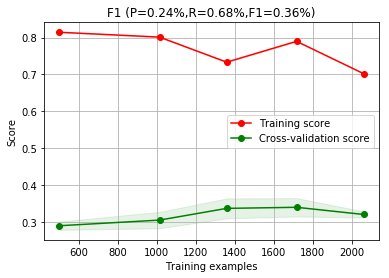

In [127]:
# with LSTM

from MLutils import custom_learning_curve

train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   5,
    'dropout':    0.25,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 64,
    'dev_ckpt_delay': 0,
    'X_dev': val_cands, 
    'Y_dev': y_val,
    'verbose': False,
}

train_sizes, train_mse, train_f1, valid_mse , valid_f1 , test_prf1 = custom_learning_curve(
    clf, train_cands[500:],y_train[500:], val_cands, y_val, X_init= train_cands[:500], y_init=y_train[:500],
                      X_test = test_cands, y_test = y_test, fit_params = train_kwargs
                     )

plot_learning_curve(train_mse,valid_mse,train_sizes, 'MSE (P=%.2f%%,R=%.2f%%,F1=%.2f%%)'%(test_prf1))

plot_learning_curve(train_f1,valid_f1,train_sizes, title='F1 (P=%.2f%%,R=%.2f%%,F1=%.2f%%)'%(test_prf1))


In [51]:
X_train

array([-1, -1, -1, ..., -1, -1, -1])

In [220]:
train_sizes_abs, train_scores, test_scores = learning_curve(
    LogisticRegression(),
    X_train, y_train, 
    scoring = mse_scorer
)


In [221]:
train_sizes_abs

array([ 438, 1424, 2411, 3397, 4384])

In [222]:
train_scores

array([[-0.02739726, -0.0913242 , -0.0913242 ],
       [-0.11516854, -0.11235955, -0.11235955],
       [-0.17917876, -0.13936126, -0.15429282],
       [-0.22019429, -0.19546659, -0.184869  ],
       [-0.23722628, -0.21441606, -0.19616788]])

In [226]:
np.mean(train_scores, axis=1)

array([-0.07001522, -0.11329588, -0.15761095, -0.20017663, -0.21593674])

<module 'matplotlib.pyplot' from '/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

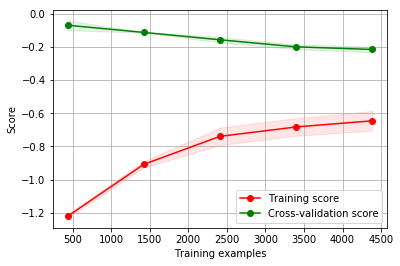

In [227]:
plot_learning_curve(test_scores, train_scores, train_sizes_abs)

In [190]:
train_sizes

[1000, 2840, 4066, 5349, 6576]

In [185]:
train_mse

array([[-0.1093275 ],
       [-0.09710326],
       [-0.09047901],
       [-0.08456929],
       [-0.08273065]])

In [162]:
train_f1

array([[ 0.71879887],
       [ 0.81435143],
       [ 0.8458771 ],
       [ 0.86775214],
       [ 0.87786869]])

In [163]:
valid_mse

array([[-0.16188714, -0.17113784, -0.17592593],
       [-0.15726179, -0.160037  , -0.15833333],
       [-0.15448659, -0.15633673, -0.15462963],
       [-0.15078631, -0.15911193, -0.14537037],
       [-0.14616096, -0.15356152, -0.15092593]])

In [164]:
valid_f1

array([[ 0.48377581,  0.43425076,  0.39102564],
       [ 0.55026455,  0.53116531,  0.51558074],
       [ 0.56847545,  0.56777494,  0.54495913],
       [ 0.5914787 ,  0.5678392 ,  0.57908847],
       [ 0.6127451 ,  0.58706468,  0.56992084]])

In [165]:
test_prf1

(array([ 0.91092512,  0.90718954]),
 array([ 0.97723264,  0.69959677]),
 array([ 0.9429146 ,  0.78998293]))

In [166]:
from MLutils import plot_learning_curve

In [169]:
test_prf1

(array([ 0.91092512,  0.90718954]),
 array([ 0.97723264,  0.69959677]),
 array([ 0.9429146 ,  0.78998293]))

In [63]:
clf.__class__

sklearn.linear_model.logistic.LogisticRegression

In [110]:
a = np.array(mse_train).reshape((-1,1))

In [104]:
valid_mse

array([[-0.74745606, -0.71415356, -0.75925926],
       [-0.74745606, -0.71415356, -0.75925926],
       [-0.74745606, -0.71415356, -0.75925926],
       [-0.74745606, -0.71415356, -0.75925926],
       [-0.74745606, -0.71415356, -0.75925926]])

In [107]:
clf_name = str(clf.__class__).split('.')[-1].split("'")[0]

In [118]:
print p,r,f1

[ 0.80242567  0.84810127] [ 0.98653199  0.23639113] [ 0.88500539  0.36972803]


## Plot learning curves

In [66]:
from learning_curves import learning_curve

In [33]:
from scipy.sparse import vstack
import numpy as np

In [34]:
X_all = vstack((X_train,X_val))
y_all = (y_train.append(y_val)).values
X_all_split = np.array([0 for i in enumerate(X_train)] + [1 for i in enumerate(X_val)])

In [256]:
X_train

<6576x77657 sparse matrix of type '<type 'numpy.float64'>'
	with 317640 stored elements in Compressed Sparse Row format>

In [36]:
X_all_split.shape

(16249,)

In [65]:
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
f1_scorer = make_scorer(f1_score, greater_is_better=True)


In [66]:
train_sizes, train_scores, valid_scores = learning_curve(
    AdaBoostClassifier(n_estimators=75),
    X_all, y_all, 
    #train_sizes=range(1000, X_train.shape[0], 1000), 
    groups = X_all_split,
    scoring = mse_scorer
)


In [67]:
train_scores

array([[-0.41366574, -0.33979686, -0.33979686],
       [-0.59772727, -0.56931818, -0.56931818],
       [-0.63521907, -0.62581836, -0.63857646],
       [-0.64665237, -0.6285442 , -0.63092685],
       [-0.63995569, -0.64069424, -0.64401773]])

In [68]:
valid_scores

array([[-0.8669005 , -0.86616208, -0.90858726],
       [-0.76056858, -0.79527414, -0.80590951],
       [-0.6741739 , -0.76352224, -0.76306556],
       [-0.73620085, -0.73103194, -0.74607572],
       [-0.71847886, -0.73472402, -0.69953832]])

In [69]:
train_sizes

array([ 1083,  3520,  5957,  8394, 10832])

In [95]:
from MLutils import plot_learning_curve

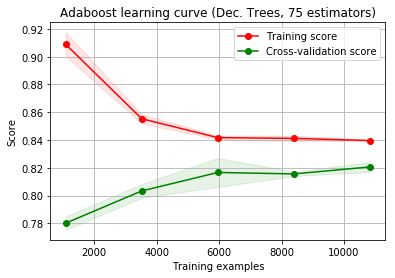

In [61]:
plot_learning_curve(train_scores, 
                        valid_scores,
                        train_sizes=train_sizes,
                   title = 'Adaboost learning curve (Dec. Trees, 75 estimators)')

plt.show()

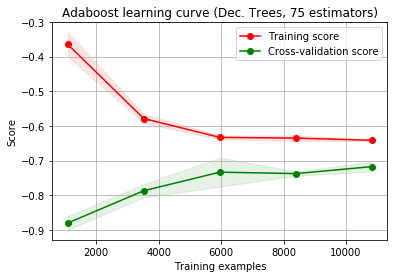

In [70]:
plot_learning_curve(train_scores, 
                        valid_scores,
                        train_sizes=train_sizes,
                   title = 'Adaboost learning curve (Dec. Trees, 75 estimators)')

plt.show()

In [71]:
## F1 score

In [72]:
train_sizes, train_scores, valid_scores = learning_curve(
    AdaBoostClassifier(n_estimators=75 ),
    X_all, y_all, 
    #train_sizes=range(1000, X_train.shape[0], 1000), 
    groups = X_all_split,
    scoring = f1_scorer
)


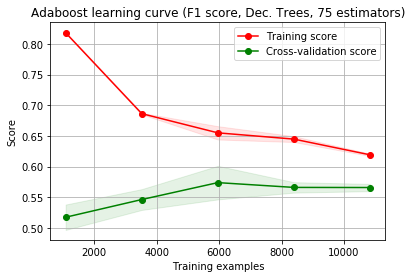

In [74]:
plot_learning_curve(train_scores, 
                        valid_scores,
                        train_sizes=train_sizes,
                   title = 'Adaboost learning curve (F1 score, Dec. Trees, 75 estimators)')

plt.show()

** With Linear SVC **

In [88]:
from sklearn.svm import SVC

In [75]:
# estimators = range(50,351,150)
estimators = [1,5,25] #+range(50,351,25)

scores_df = pd.DataFrame(index=estimators)



for n in estimators:
    clf = AdaBoostClassifier(n_estimators=n, 
                             base_estimator = LinearSVC,
                             algorithm='SAMME'
                            )
    clf.fit(X_train,y_train)
    
    pred = clf.predict(X_train)
    scores_df.loc[n,'f1_train'] = f1_score(y_train,pred)
    pred = clf.predict(X_val)
    scores_df.loc[n,'f1_val'] = f1_score(y_val,pred)
#     scores_df['train_score'] = clf.score(X_train,y_train)



# scores = validation_curve(clf, X_train, y_train,
#                          'n_estimators', estimators)


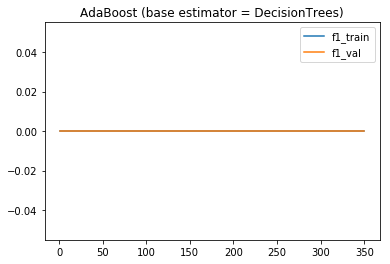

In [83]:
scores_df.plot(title='AdaBoost (base estimator = LR)')

## BrownBoost

In [79]:
from MLutils import BrownBoost

In [80]:
from sklearn.tree import DecisionTreeClassifier

In [81]:
# prediction = brownboost.predict(X_test)
# accuracy = accuracy_score(y_test, prediction)
# precision = precision_score(y_test, prediction, pos_label=1, labels=[-1, 1])
# recall = recall_score(y_test, prediction, pos_label=1, labels=[-1, 1])
# clf_f1_score = f1_score(y_test, prediction, pos_label=1, labels=[-1, 1])
# print("mean accuracy : %.4f \n" % accuracy)
# precision, recall, clf_f1_score

In [110]:
base_estimator = DecisionTreeClassifier(max_depth=1)
brownboost = BrownBoost(base_estimator, c=1)
st_time = time.time()

brownboost.fit(X_train, np.array(y_train))
pred = brownboost.predict(X_train)
f1_train = f1_score(y_train,pred)
pred = brownboost.predict(X_val)
f1_val = f1_score(y_val,pred)
print f1_train,f1_val
print time.time()-st_time

0.724848915748 0.573268921095
808.138631821


In [76]:
## BrownBoost learning curves

In [77]:
import time

In [93]:
from MLutils import BrownBoost

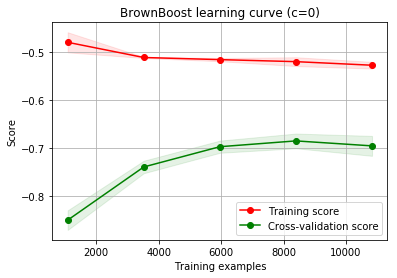

5793.73460007


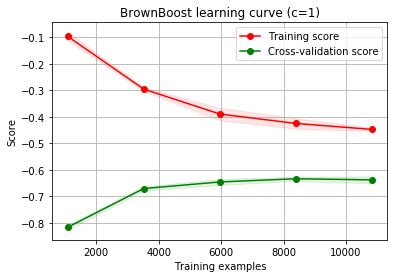

8870.76387811


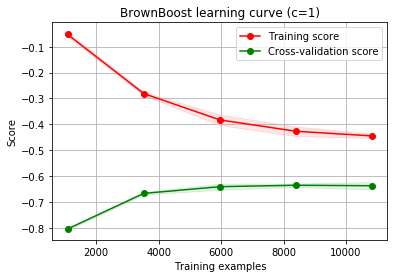

8856.51826715


In [113]:
#define BrownBoost hyperparams

for c in [.5,1,1.5]:

    base_estimator = DecisionTreeClassifier(max_depth=1)

    st_time = time.time()
    train_sizes, train_scores, valid_scores = learning_curve(
        BrownBoost(base_estimator, c=c) ,
        X_all, y_all, 
        #train_sizes=range(1000, X_train.shape[0], 1000), 
        groups = X_all_split,
        scoring = mse_scorer,
        n_jobs = -1

    )

    plot_learning_curve(train_scores, 
                            valid_scores,
                            train_sizes=train_sizes,
                       title = 'BrownBoost learning curve (c=%.2f)'%c)

    plt.show()
    print time.time()-st_time

## RobustBoost

In [113]:
from MLutils import RobustBoost

In [114]:
from sklearn.tree import DecisionTreeClassifier

In [117]:
base_estimator = DecisionTreeClassifier(max_depth=1)
robustboost = RobustBoost(base_estimator)

In [118]:
# prediction = brownboost.predict(X_test)
# accuracy = accuracy_score(y_test, prediction)
# precision = precision_score(y_test, prediction, pos_label=1, labels=[-1, 1])
# recall = recall_score(y_test, prediction, pos_label=1, labels=[-1, 1])
# clf_f1_score = f1_score(y_test, prediction, pos_label=1, labels=[-1, 1])
# print("mean accuracy : %.4f \n" % accuracy)
# precision, recall, clf_f1_score

In [119]:
# robustboost.fit(X_train, np.array(y_train))
# pred = robustboost.predict(X_train)
# f1_train = f1_score(y_train,pred)
# pred = robustboost.predict(X_val)
# f1_val = f1_score(y_val,pred)
# print f1_train,f1_val

NameError: global name 't' is not defined